## using only 2 landmarks in GaussianKernel #2

In [1]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
import sys
sys.path.append('/home/admin/github/wordroid.sblo.jp/lib')
from keras_ex.GaussianKernel import GaussianKernel, GaussianKernel2

# or copy and paste the definition of `GaussianKernel` here.

In [3]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import cluster, datasets, mixture
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from keras.layers import Input, Embedding, LSTM, GRU, Dense, Dropout, Lambda, \
    Conv1D, Conv2D, Conv3D, \
    Conv2DTranspose, \
    AveragePooling1D, \
    MaxPooling1D, MaxPooling2D, MaxPooling3D, \
    GlobalAveragePooling1D, \
    GlobalMaxPooling1D, GlobalMaxPooling2D, \
    LocallyConnected1D, LocallyConnected2D, \
    concatenate, Flatten, Average, Activation, \
    RepeatVector, Permute, Reshape, Dot, \
    multiply, dot, add, \
    PReLU, \
    Bidirectional, TimeDistributed, \
    SpatialDropout1D, \
    BatchNormalization
from keras.models import Model, Sequential
from keras import losses
from keras.callbacks import BaseLogger, ProgbarLogger, Callback, History
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers
from keras import initializers
from keras.metrics import categorical_accuracy
from keras.constraints import maxnorm, non_neg
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras import backend as K

In [4]:
digits = load_digits()
X, y = digits.data, digits.target
X[:5]

array([[  0.,   0.,   5.,  13.,   9.,   1.,   0.,   0.,   0.,   0.,  13.,
         15.,  10.,  15.,   5.,   0.,   0.,   3.,  15.,   2.,   0.,  11.,
          8.,   0.,   0.,   4.,  12.,   0.,   0.,   8.,   8.,   0.,   0.,
          5.,   8.,   0.,   0.,   9.,   8.,   0.,   0.,   4.,  11.,   0.,
          1.,  12.,   7.,   0.,   0.,   2.,  14.,   5.,  10.,  12.,   0.,
          0.,   0.,   0.,   6.,  13.,  10.,   0.,   0.,   0.],
       [  0.,   0.,   0.,  12.,  13.,   5.,   0.,   0.,   0.,   0.,   0.,
         11.,  16.,   9.,   0.,   0.,   0.,   0.,   3.,  15.,  16.,   6.,
          0.,   0.,   0.,   7.,  15.,  16.,  16.,   2.,   0.,   0.,   0.,
          0.,   1.,  16.,  16.,   3.,   0.,   0.,   0.,   0.,   1.,  16.,
         16.,   6.,   0.,   0.,   0.,   0.,   1.,  16.,  16.,   6.,   0.,
          0.,   0.,   0.,   0.,  11.,  16.,  10.,   0.,   0.],
       [  0.,   0.,   0.,   4.,  15.,  12.,   0.,   0.,   0.,   0.,   3.,
         16.,  15.,  14.,   0.,   0.,   0.,   0.,   8.,  13.

In [5]:
X = X.reshape((X.shape[0], -1))
X[:5]

array([[  0.,   0.,   5.,  13.,   9.,   1.,   0.,   0.,   0.,   0.,  13.,
         15.,  10.,  15.,   5.,   0.,   0.,   3.,  15.,   2.,   0.,  11.,
          8.,   0.,   0.,   4.,  12.,   0.,   0.,   8.,   8.,   0.,   0.,
          5.,   8.,   0.,   0.,   9.,   8.,   0.,   0.,   4.,  11.,   0.,
          1.,  12.,   7.,   0.,   0.,   2.,  14.,   5.,  10.,  12.,   0.,
          0.,   0.,   0.,   6.,  13.,  10.,   0.,   0.,   0.],
       [  0.,   0.,   0.,  12.,  13.,   5.,   0.,   0.,   0.,   0.,   0.,
         11.,  16.,   9.,   0.,   0.,   0.,   0.,   3.,  15.,  16.,   6.,
          0.,   0.,   0.,   7.,  15.,  16.,  16.,   2.,   0.,   0.,   0.,
          0.,   1.,  16.,  16.,   3.,   0.,   0.,   0.,   0.,   1.,  16.,
         16.,   6.,   0.,   0.,   0.,   0.,   1.,  16.,  16.,   6.,   0.,
          0.,   0.,   0.,   0.,  11.,  16.,  10.,   0.,   0.],
       [  0.,   0.,   0.,   4.,  15.,  12.,   0.,   0.,   0.,   0.,   3.,
         16.,  15.,  14.,   0.,   0.,   0.,   0.,   8.,  13.

In [6]:
X_sc = X / 16.0
X_sc.shape

(1797, 64)

In [7]:
X_sc

array([[ 0.    ,  0.    ,  0.3125, ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.625 ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  1.    ,  0.5625,  0.    ],
       ..., 
       [ 0.    ,  0.    ,  0.0625, ...,  0.375 ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.125 , ...,  0.75  ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.625 , ...,  0.75  ,  0.0625,  0.    ]])

In [8]:
y

array([0, 1, 2, ..., 8, 9, 8])

In [9]:
y_cat = to_categorical(y)
y_cat

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

### create model

In [10]:
'''
chose landmarks from sample
pick 10 data each digit
'''
np.random.seed(0)
num_lm0 = 10
num_lm = num_lm0 * 10
init_list = []
for ii in range(10):
    init_wgt0 = X_sc[y==ii]
    init_wgt0 = init_wgt0[np.random.choice(range(init_wgt0.shape[0]), size=num_lm0, replace=False)] + \
                np.random.normal(scale=0.01, size=num_lm0*64).reshape(num_lm0, 64)
    init_list.append(init_wgt0)
init_wgt = np.vstack(init_list)
init_wgt = init_wgt[np.random.permutation(range(init_wgt.shape[0]))]
init_wgt.shape

(100, 64)

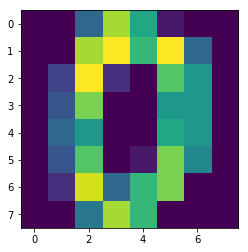

In [11]:
plt.imshow(X[0].reshape((8,8)))

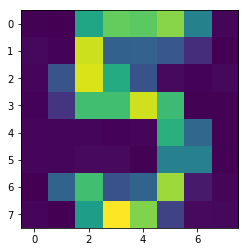

In [12]:
plt.imshow(init_wgt[0].reshape((8,8)))

In [13]:
np.random.seed(0)
num_lm2 = 2

print(1./(2.*num_lm*0.1))
print(1./(2.*64*0.1))

def make_modelz(gamma=0, gamma_svm=0.1, name='DUMMY'):
    inp = Input(shape=(64,), name='inp')
    oup = inp
    
    oup_gk1 = GaussianKernel2(init_wgt, name='gkernel1',
                              weights=[np.log(np.array([0.078125]))], trainable=True)(oup)
    #oup_gk1 = GaussianKernel(num_lm, 64, kernel_gamma=1./(2.*64*0.1), weights=[init_wgt], trainable=False, name='gkernel1')(oup)
    model_gk1 = Model(inp, oup_gk1)
    
    oup_gk2 = GaussianKernel(num_lm2, num_lm, kernel_gamma=1./(2.*num_lm*0.1), name='gkernel2')(oup_gk1)
    #oup_gk2 = GaussianKernel(num_lm2, num_lm, kernel_gamma='auto', name='gkernel2')(oup_gk1)
    model_gk2 = Model(inp, oup_gk2)
    
    oup = Dense(10, activation='softmax')(oup_gk2)
    
    model = Model(inp, oup)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return {
        'model': model,
        'model_gk1': model_gk1,
        'model_gk2': model_gk2,
        #'model_gk3': model_gk3,
    }

models = make_modelz()
model = models['model']
model.summary()

0.05
0.078125
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             (None, 64)                0         
_________________________________________________________________
gkernel1 (GaussianKernel2)   (None, 100)               1         
_________________________________________________________________
gkernel2 (GaussianKernel)    (None, 2)                 200       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                30        
Total params: 231
Trainable params: 231
Non-trainable params: 0
_________________________________________________________________


### train

In [14]:
model.fit(X_sc, y_cat, verbose=0,
          batch_size=32,
          epochs=6000)

/home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


### predict

In [15]:
y_pred = model.predict(X_sc, batch_size=1024)
y_pred

array([[  8.90883982e-01,   3.89741181e-04,   8.78367806e-04, ...,
          7.60653074e-06,   1.05133075e-02,   3.37263644e-02],
       [  2.96392973e-04,   4.61895615e-01,   5.04407994e-02, ...,
          2.31157020e-01,   8.88228267e-02,   4.63628443e-03],
       [  7.90291873e-04,   4.17701364e-01,   8.03879127e-02, ...,
          2.05515608e-01,   1.38470486e-01,   1.14668785e-02],
       ..., 
       [  9.85434093e-03,   3.56776893e-01,   2.52912045e-02, ...,
          3.82496417e-02,   1.23398930e-01,   1.02269528e-02],
       [  1.71128795e-01,   1.26537643e-02,   5.36833964e-02, ...,
          2.07320531e-03,   1.56966239e-01,   2.73654133e-01],
       [  7.54418522e-02,   7.90786296e-02,   7.80535042e-02, ...,
          1.29480027e-02,   2.48565674e-01,   1.35243550e-01]], dtype=float32)

In [16]:
confusion_matrix(y, np.argmax(y_pred, axis=1))

array([[170,   0,   0,   0,   0,   2,   5,   0,   0,   1],
       [  0, 123,   3,   0,   7,   1,   4,  24,  20,   0],
       [  0,   7, 115,  29,   0,   3,   0,   5,  18,   0],
       [  0,   0,  13, 145,   0,   4,   0,   4,   0,  17],
       [  0,   5,   0,   0, 168,   0,   5,   3,   0,   0],
       [  3,  11,   9,   0,   1,  83,   1,   0,  20,  54],
       [  2,   2,   0,   0,   3,   0, 174,   0,   0,   0],
       [  0,  20,   3,   0,   0,   0,   0, 155,   1,   0],
       [  1,  26,  31,   0,   0,  47,   0,   3,  41,  25],
       [  0,  10,   9,   8,   0,   8,   0,   2,  13, 130]])

In [17]:
print(classification_report(y, np.argmax(y_pred, axis=1)))

             precision    recall  f1-score   support

          0       0.97      0.96      0.96       178
          1       0.60      0.68      0.64       182
          2       0.63      0.65      0.64       177
          3       0.80      0.79      0.79       183
          4       0.94      0.93      0.93       181
          5       0.56      0.46      0.50       182
          6       0.92      0.96      0.94       181
          7       0.79      0.87      0.83       179
          8       0.36      0.24      0.29       174
          9       0.57      0.72      0.64       180

avg / total       0.72      0.73      0.72      1797



### plot output of GaussianKernel layer #1

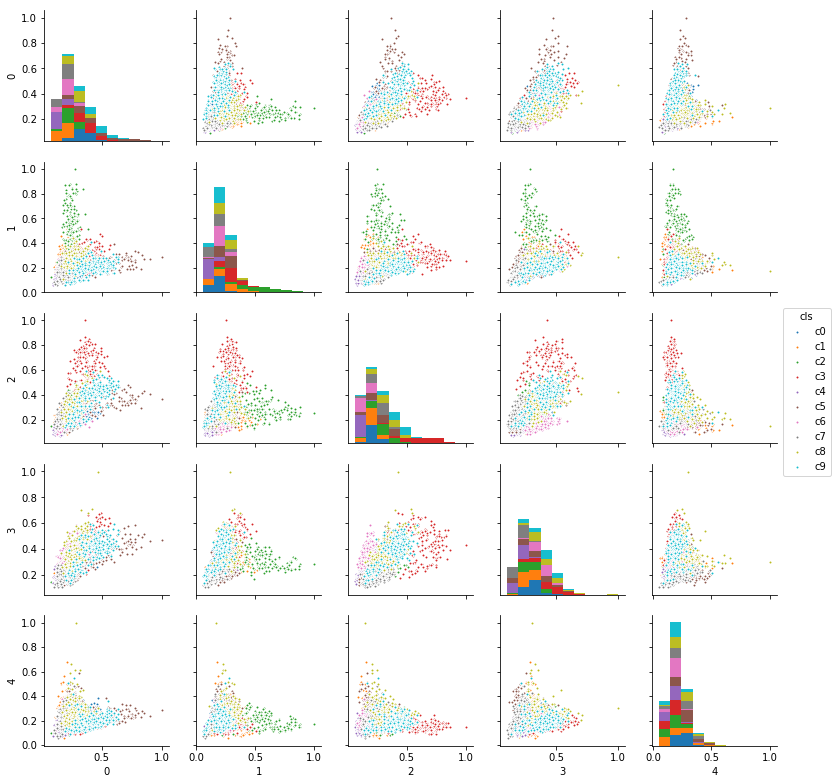

In [18]:
gk1_pred = models['model_gk1'].predict(X_sc, batch_size=1024)
df = pd.DataFrame(gk1_pred[:,:5])
df['cls'] = ['c'+str(ee) for ee in y]
sns.pairplot(df, markers='.', hue='cls', size=2.2)

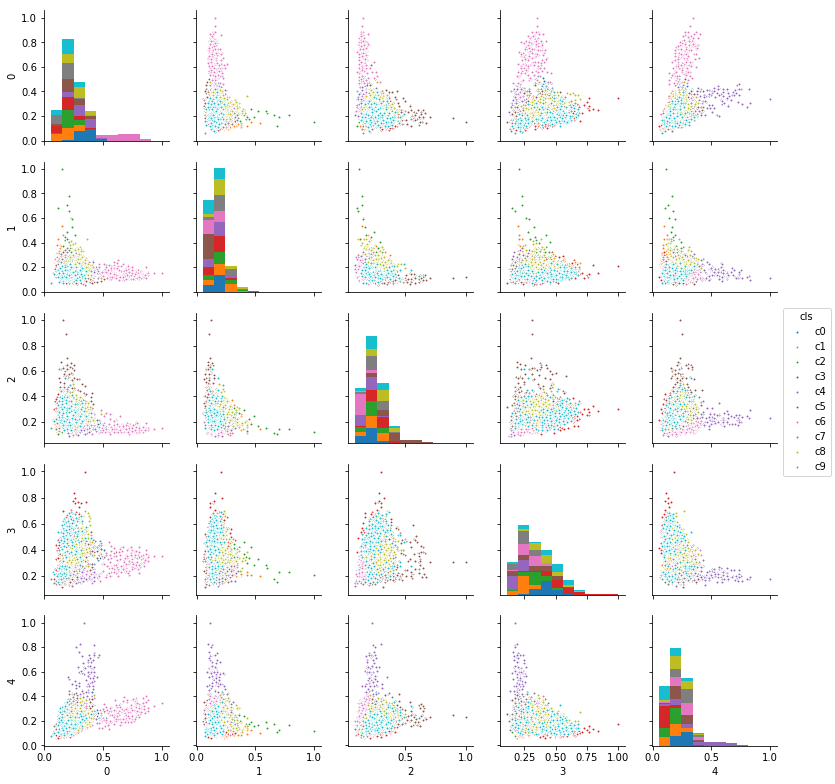

In [19]:
df = pd.DataFrame(gk1_pred[:,50:55])
df['cls'] = ['c'+str(ee) for ee in y]
sns.pairplot(df, markers='.', hue='cls', size=2.2)

In [20]:
'''gamma of GaussianKernel layer #1'''
np.exp(models['model_gk2'].get_layer('gkernel1').get_weights()[0])

array([ 0.15635847], dtype=float32)

### plot output of GaussianKernel layer #2

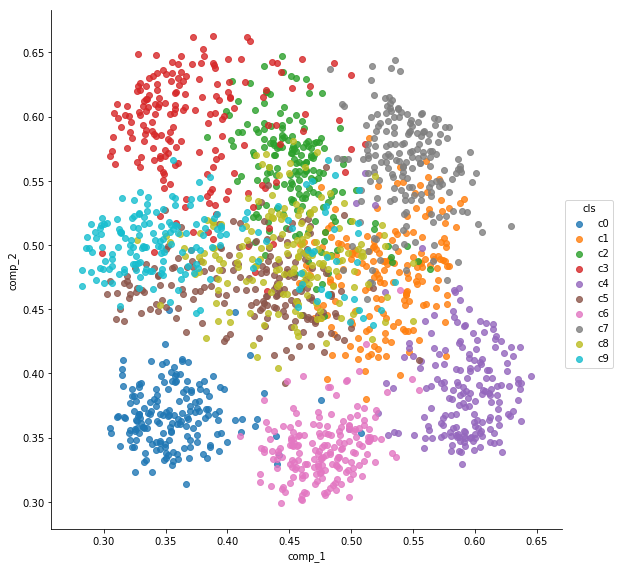

In [21]:
gk2_pred = models['model_gk2'].predict(X_sc, batch_size=1024)
df = pd.DataFrame(gk2_pred[:,:5])
df.columns = ["comp_1", "comp_2"]
df['cls'] = ['c'+str(ee) for ee in y]
sns.lmplot("comp_1", "comp_2", hue = "cls", data=df, fit_reg=False, size=8)